In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [2]:
data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"

#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"

#data_path = "../thesis/dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))
#ind = 0


molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test, p_test = S.reshape(-1, dim, dim), P.reshape(-1, dim, dim)

# Fock and Utilities 

In [4]:
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [5]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


In [6]:
f_test = fock_from_density_batch(p_test)

# Calculate Guesses 

## Classical 

In [7]:
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
])

In [8]:
p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
])

## E-GWH

In [9]:
from SCFInitialGuess.construction.fock import gwh_scheme

def gwh_scheme_wrapper(M, k=1.75):
    F = []
    for m, s in zip(M, s_test):
        F.append(gwh_scheme(np.diag(m), s, k))
        
    return np.array(F)

In [10]:
f_egwh = gwh_scheme_wrapper(f_test)
p_egwh = density_from_fock_batch(f_egwh)

## E-GWH+ & Embedded GWH 

In [11]:
from SCFInitialGuess.construction.utilities import make_center_mask, embed_batch

mask_center = make_center_mask(molecules[1][0])

In [12]:
f_egwh_plus = embed_batch(f_egwh, f_test, mask_center)
p_egwh_plus = density_from_fock_batch(f_egwh_plus)

In [14]:
f_embedded_gwh = embed_batch(gwh_scheme_wrapper(h_test), f_test, mask_center)
p_embedded_gwh = density_from_fock_batch(f_embedded_gwh)

# Plots

In [21]:
index = np.arange(len(p_test))
np.random.shuffle(index)
index_max = 30
index = index[:index_max]

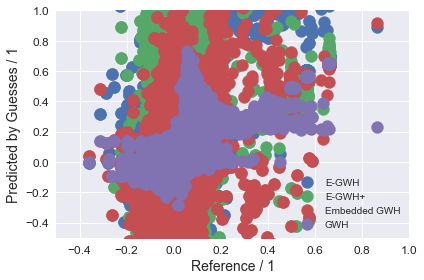

In [29]:
expected = p_test[index].flatten()

plt.scatter(expected, p_egwh[index].flatten(), label="E-GWH")
plt.scatter(expected, p_egwh_plus[index].flatten(), label="E-GWH+")
plt.scatter(expected, p_embedded_gwh[index].flatten(), label="Embedded GWH")
plt.scatter(expected, p_gwh[index].flatten(), label="GWH")



plt.xlim([-0.5, 1.0])
plt.ylim([-0.5, 1.0])

plt.ylabel("Predicted by Guesses / 1")
plt.xlabel("Reference / 1")

plt.legend()
plt.tight_layout()

plt.savefig("/home/jo/Repos/MastersThesis/DensityGuessSchemes/figures/PredictionScatterGWHs.png")

plt.show()